In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST

In [5]:
print(torch.__version__)

1.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#import os
#os.chdir("/content/drive/My Drive") 
import ra
#import complexLayers


In [3]:
dataset = ra.read('atomsroa.ra')
train_data = torch.tensor(dataset)

In [4]:
train_data = train_data.imag
train_data =  torch.transpose(train_data, 0, 1)

In [5]:
labelset = ra.read('paramsroa.ra')
train_label1 = torch.tensor(labelset)

In [6]:
dataset1 = ra.read('atoms.ra')
traindata1 = torch.tensor(dataset1)
traindata1 = traindata1.imag
traindata1 =  torch.transpose(traindata1, 0, 1)
label1 = ra.read('params.ra')
label1 = torch.tensor(label1)

In [18]:
print(traindata1)
print(train_data)

tensor([[[ 0.0038,  0.0015, -0.0007,  ..., -0.0274, -0.0272, -0.0269]],

        [[ 0.0045,  0.0023,  0.0001,  ..., -0.0279, -0.0276, -0.0273]],

        [[ 0.0052,  0.0031,  0.0010,  ..., -0.0283, -0.0280, -0.0278]],

        ...,

        [[ 0.0215,  0.0229,  0.0242,  ..., -0.0250, -0.0246, -0.0243]],

        [[ 0.0216,  0.0230,  0.0243,  ..., -0.0250, -0.0246, -0.0243]],

        [[ 0.0216,  0.0230,  0.0243,  ..., -0.0250, -0.0247, -0.0243]]],
       dtype=torch.float64)
tensor([[[-0.0100, -0.0114, -0.0094,  ...,  0.0324,  0.0322,  0.0320]],

        [[-0.0105, -0.0123, -0.0106,  ...,  0.0329,  0.0327,  0.0325]],

        [[-0.0110, -0.0132, -0.0117,  ...,  0.0333,  0.0331,  0.0330]],

        ...,

        [[-0.0141, -0.0290, -0.0443,  ...,  0.0006,  0.0012,  0.0019]],

        [[-0.0141, -0.0290, -0.0443,  ...,  0.0006,  0.0012,  0.0019]],

        [[-0.0141, -0.0289, -0.0443,  ...,  0.0006,  0.0012,  0.0019]]],
       dtype=torch.float64)


In [7]:
print(traindata1.shape)
train_data.shape

torch.Size([108056, 1000])


torch.Size([108056, 1000])

In [8]:
alldata = torch.cat((train_data,traindata1),0)

In [9]:
alldata.shape

torch.Size([216112, 1000])

In [10]:
labels1 = torch.cat((train_label1[0,:],label1[0,:]),0)

In [11]:
print(labels1)
print(labels1.shape)
print(train_label1.shape)

tensor([ 100.,  110.,  120.,  ..., 3980., 3990., 4000.], dtype=torch.float64)
torch.Size([216112])
torch.Size([3, 108056])


In [27]:
labels1 = torch.transpose(labels1, 0, 1)
print(labels1.shape)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [12]:
import torch.utils.data as data
train_dataset = data.TensorDataset(alldata,labels1)

In [ ]:
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=10).fit_transform(train_data)

In [ ]:
pca = PCA(n_components=10)
pca.fit(train_data)

print(pca.explained_variance_ratio_.shape)
print(pca.components_.shape)
print(pca.singular_values_.shape)
print(pca.mean_.shape)

In [ ]:
train_data = torch.tensor(X_reduced)

In [13]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [140000, 60000 ,16112])

We found that the network model with smallest
average error for validation data consists of 3 convolutional layers (kernel size = 3, stride
size = 2), each followed by a rectified linear unit (ReLU) activation function. The number
of the feature maps per convolutional layer is increasing, from 32 in the first to 128 in
the last. After convolution an average pooling layer follows with the same size as the
stride size. The last layer is fully connected, with 2 outputs. 

In [14]:

def _batch_norm(x):
  eps_ = torch.finfo(torch.float32).eps
  y = (x - torch.mean(x)) / (torch.std(x) + eps_)
  return y


# define baseline model
class BaselineModel1(nn.Module):
    def __init__(self):
        super(BaselineModel1, self).__init__()
        self.fc1 = nn.Linear(1000, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)


    def forward(self, x):
        #print(x)
        out = self.fc1(x)
        #print(out)
        #raise error
        out = _batch_norm(out)
        #out = self.bn(512)
        out = torch.sigmoid(out)
        out = self.fc2(out)
        #out = self.bn(256)
        out = _batch_norm(out)
        out = torch.sigmoid(out)
        out = self.fc3(out)
        return out

In [15]:
N = 200
val_loss = list()
#val_accu = list()
train_loss = list()
#train_accu = list()

In [16]:
#assert torch.cuda.is_available()
device1 = "cuda:0" if torch.cuda.is_available() else "cpu"
#cuda_device = torch.device("cuda")
seed = 7
torch.manual_seed(seed)
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

def loss_batch(model, loss_func, xb, yb, opt=None):
    outputs = model(xb.float())
    yb = yb.float()
    outputs = torch.squeeze(outputs, 1)
    loss = loss_func(outputs, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [ ]:
!pip install pycuda
import torch
import pycuda.driver as cuda
cuda.init()
## Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name() # '0' is the id of your GPU

In [25]:

# build the model
model = BaselineModel1().to(device1)

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

# the epoch loop
for epoch in range(N):
    model.train()
    running_loss = 0.0
    loss=0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        #inputs = inputs.unsqueeze(1).unsqueeze(-1)
        #inputs = inputs.unsqueeze(1)
        #inputs = torch.unsqueeze(inputs1, 2)

        inputs, labels = inputs.to(device1), labels.to(device1)
        
        
        loss, nums = loss_batch(model, loss_function, inputs.float(), labels.float(), optimiser)
        running_loss += loss
    train_loss.append(loss)

    model.eval()
    with torch.no_grad():
        losses, nums = zip(
                *[loss_batch(model.to(device1), loss_function, xb.to(device1), yb.to(device1)) for xb, yb in validloader]
            )
        val_loss1 = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_loss.append(val_loss1)


        #print(epoch, val_loss)

        
        # keep track of the loss this epoch
        #running_loss += loss.item()
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
print('**** Finished Training ****')

Epoch 0, loss 7123311915.00
Epoch 1, loss 6294505022.50
Epoch 2, loss 5537295320.25
Epoch 3, loss 4837479366.50
Epoch 4, loss 4190843803.25
Epoch 5, loss 3594807784.00
Epoch 6, loss 3048559769.50
Epoch 7, loss 2550560539.50
Epoch 8, loss 2101658948.12
Epoch 9, loss 1699633160.69
Epoch 10, loss 1345431611.62
Epoch 11, loss 1036352391.47
Epoch 12, loss 772892895.62
Epoch 13, loss 552723509.05
Epoch 14, loss 375139437.50
Epoch 15, loss 238251767.15
Epoch 16, loss 138448713.09
Epoch 17, loss 72120789.40
Epoch 18, loss 33516685.79
Epoch 19, loss 15509882.71
Epoch 20, loss 10455107.43
Epoch 21, loss 9698166.19
Epoch 22, loss 9195556.98
Epoch 23, loss 8907277.90
Epoch 24, loss 8298854.85
Epoch 25, loss 8795994.37
Epoch 26, loss 8695972.99
Epoch 27, loss 8270403.73
Epoch 28, loss 8290156.04
Epoch 29, loss 7916375.84
Epoch 30, loss 7995027.14
Epoch 31, loss 8785986.84
Epoch 32, loss 8002119.64
Epoch 33, loss 8122498.79
Epoch 34, loss 8163754.79
Epoch 35, loss 7158549.98
Epoch 36, loss 8057523.2

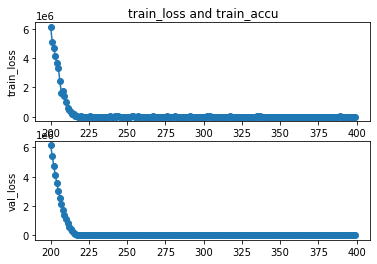

In [34]:
import matplotlib.pyplot as plt

x = range(200, 400)
y1 = train_loss[200:400]
#y2 = train_accu
y3 = val_loss[200:400]
#y4 = val_accu
plt.subplot(2, 1, 1)
plt.plot(x, y1, 'o-')
plt.title('train_loss and train_accu')
plt.ylabel('train_loss')
#plt.subplot(2, 1, 2)
#plt.plot(x, y2, '.-')
#plt.xlabel('epoches')
#plt.ylabel('train_accu')
plt.subplot(2, 1, 2)
plt.plot(x, y3, 'o-')
plt.ylabel('val_loss')
#plt.subplot(2, 2, 2)
#plt.plot(x, y4, '.-')
#plt.title('val_loss and val_accu')
#lt.ylabel('val_accu')
plt.show()
#plt.savefig("accuracy_loss.jpg")


In [19]:
print(y1)

[5917937.5, 5698459.5, 5250939.0, 4004378.75, 3816877.75, 2905402.0, 2228339.0, 2254947.5, 1507265.75, 1302897.875, 969576.625, 683137.9375, 737577.1875, 401484.8125, 507223.75, 176410.234375, 289785.46875, 5960.16748046875, 25392.48046875, 20408.96484375, 22663.66796875, 6070.8408203125, 11546.3349609375, 19351.12109375, 9340.224609375, 8161.1435546875, 3864.4375, 498.5628356933594, 17203.37890625, 13797.5966796875, 30669.615234375, 798.695068359375, 30322.46875, 6377.47021484375, 2169.087158203125, 12666.5625, 6111.06787109375, 43178.08203125, 17763.546875, 3177.236328125, 4387.10107421875, 2985.85302734375, 558.0950927734375, 10580.419921875, 2294.7783203125, 14273.087890625, 30308.154296875, 15592.142578125, 4619.44287109375, 11726.478515625, 9862.66796875, 4049.32080078125, 8182.1904296875, 2805.8330078125, 16375.4755859375, 146.3652801513672, 22780.896484375, 3872.0849609375, 2974.00146484375, 19748.4140625, 2553.81787109375, 562.6351318359375, 4241.11279296875, 5008.85693359375,

In [20]:
val_loss

[6133306.389866667,
 5411665.525333334,
 4746026.305066667,
 4129581.7648,
 3560907.1082666665,
 3038260.3537333333,
 2560283.2986666667,
 2127254.3554666666,
 1737770.0898666666,
 1391204.3045333333,
 1087462.798,
 825550.1424333333,
 603328.2445333333,
 421376.16866666666,
 277784.26081666665,
 168532.764925,
 93433.03980208334,
 47237.1807734375,
 20286.724372916666,
 10462.230557942708,
 9274.53732122396,
 8963.354599739583,
 8381.963436132812,
 8275.311824088541,
 7761.961145442709,
 7798.685552994792,
 8433.149216796875,
 7576.035002734375,
 7677.671528645833,
 7697.3348484375,
 7582.3690865234375,
 7634.113422786459,
 13274.878941666666,
 7012.657224479167,
 8155.789490625,
 7155.457526953125,
 7213.085940917968,
 7327.309209114584,
 6783.890887337239,
 8163.154492578125,
 7241.611479882812,
 6553.7299754882815,
 6816.41527171224,
 6950.913736653646,
 6635.282400390625,
 6671.637765625,
 6847.644334765625,
 6899.368176627604,
 6858.307506966145,
 7087.686218033854,
 7962.2838898

In [31]:
print(y3)

[2329.390924175304, 2329.870010027464, 2567.8847436838614, 2229.5240537308177, 2370.2302323675676, 2484.9268916413234, 2350.595354369996, 2204.2992619776796, 2602.1845383099553, 2645.505024884403, 2380.0201588150526, 2602.862652351508, 2298.221951754588, 2501.48779502952, 2443.29576206302, 2285.913119273484, 2065.4368147940004, 2229.4337262453837, 2553.1103669576637, 2364.1919620517706, 2141.5369978509807, 2283.5019674897785, 2306.446569084766, 2621.560790106462, 2229.4250456157483, 2466.742031366373, 2095.974074059707, 2017.5348306483522, 2454.340118196065, 2478.1828218098312, 2549.8317045573563, 2556.8211925396736, 2658.9880211081027, 2049.3577607504308, 2393.94337658849, 2259.482961917942, 2316.481117165195, 2212.745407695448, 2465.380058099165, 2226.1885803889377, 2402.269844214279, 2564.756735808326, 2195.5266131464514, 2148.4446269909463, 2197.6484067399783, 2425.0334536297673, 2616.7097846204497, 2217.88387306918, 2581.7366012376256, 2640.480786835899, 2314.2928791671193, 2236.8

In [ ]:
model.eval()

In [28]:
model.eval()
test_loss = list()
for data in testloader:
    losses, nums = zip(
                *[loss_batch(model.to(device1), loss_function, xb.to(device1), yb.to(device1)) for xb, yb in testloader])
    test_loss1 = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    test_loss.append(test_loss1)

In [29]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'test_loss')

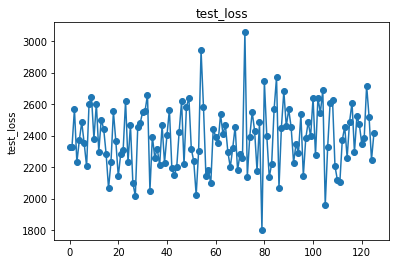

In [30]:
x = range(0, 126)
y3 = test_loss
plt.plot(x, y3, 'o-')
plt.title('test_loss')
plt.ylabel('test_loss')

In [ ]:
for data in testloader:
    inputs, lablels = data
    predictions = model(inputs.float())
    loss = loss_function(predictions,labels)
    loss = loss/128
    print("loss",loss)
    print("predicted parameter:", predictions)
    print("setting parameter:", labels)

In [ ]:
testdataset = ra.read('atomsroa.ra')
testdata = torch.tensor(testdataset)
testdata = testdata.imag
label1 = ra.read('paramsroa.ra')
label1 = torch.tensor(label1)

In [ ]:
for i in range(8056):
    inputs = testdata[:,i]
    lablels = label1[0,i]
    predictions = model(inputs.float())

    print("predicted parameter:", predictions)
    print("setting parameter:", lablels)

## Saving models

Being able to train a model is fine, but in practice once we've trained the model we probably want to save the result so we can reuse it at a later time. PyTorch makes saving the model easy using the torch.save(state, filepath) function. This will save the weights of the model so they can be loaded into a new instance at a later point.

Run the following code to save the weights for use in the next part of the lab.

In [17]:
#save the trained model weights
torch.save(model.state_dict(), "./BaselineModel1.weights")

If you are running on Colab, run the following to download the weights to the local machine:

In [ ]:
from google.colab import files
files.download('BaselineModel.weights')

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = BaselineModel(1000, 512, 256).to(device)
model.load_state_dict(torch.load('BaselineModel.weights'))